In [2]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

In [3]:
dataset_dir = "dataset FER/train"
classes = ["angry", "fear", "happy", "neutral", "sad", "surprise"]

image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")
    print(f"Class: {class_name}, Files Found: {len(files)}")
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: angry, Files Found: 3995
Class: fear, Files Found: 4097
Class: happy, Files Found: 7215
Class: neutral, Files Found: 4965
Class: sad, Files Found: 4830
Class: surprise, Files Found: 3171


In [4]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_paths)}, Testing images: {len(test_paths)}")

Total images: 28273
Training images: 22618, Testing images: 5655


In [5]:
train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.transform(test_labels)

IMG_HEIGHT, IMG_WIDTH = 224, 224

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image

def load_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset

train_dataset = load_dataset(train_paths, train_labels)
test_dataset = load_dataset(test_paths, test_labels)

BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2025-07-20 21:08:37.701292: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])
    return model

model = build_model()
model.summary()

/home/revanth1206/Revanth/pyml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 20
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

model.save("FER_model.h5")

Epoch 1/20


707/707 ━━━━━━━━━━━━━━━━━━━━ 430s 605ms/step - accuracy: 0.2590 - loss: 1.7947 - val_accuracy: 0.3546 - val_loss: 1.5911
Epoch 2/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 431s 610ms/step - accuracy: 0.3745 - loss: 1.5504 - val_accuracy: 0.4364 - val_loss: 1.4344
Epoch 3/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 431s 609ms/step - accuracy: 0.4334 - loss: 1.4117 - val_accuracy: 0.4529 - val_loss: 1.3938
Epoch 4/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 432s 610ms/step - accuracy: 0.4778 - loss: 1.3164 - val_accuracy: 0.4702 - val_loss: 1.3653
Epoch 5/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 428s 605ms/step - accuracy: 0.5248 - loss: 1.2134 - val_accuracy: 0.4792 - val_loss: 1.3700
Epoch 6/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 426s 603ms/step - accuracy: 0.5662 - loss: 1.1174 - val_accuracy: 0.4815 - val_loss: 1.3960
Epoch 7/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 320s 452ms/step - accuracy: 0.6061 - loss: 1.0084 - val_accuracy: 0.4787 - val_loss: 1.5181
Epoch 8/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 295s 417ms/step - accuracy: 0.6353 - loss: 0.93

177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.4839 - loss: 2.3979
Test Loss: 2.4709, Test Accuracy: 0.4766


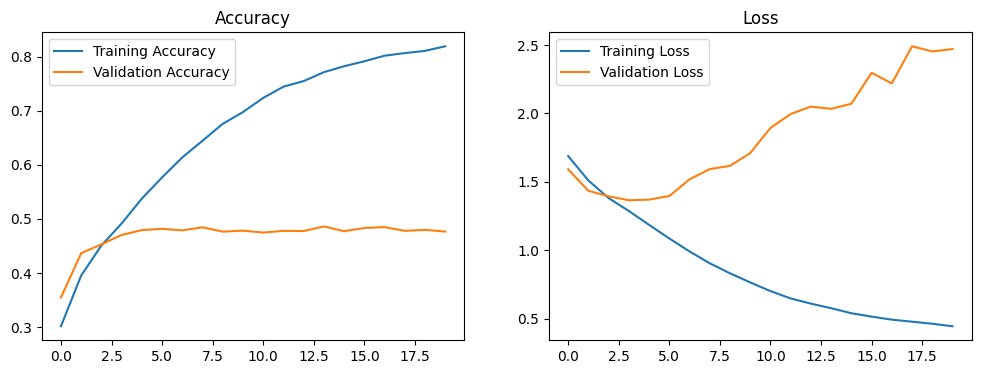

In [9]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)

177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.37      0.36      0.36       799
        fear       0.38      0.32      0.35       820
       happy       0.64      0.65      0.64      1443
     neutral       0.45      0.44      0.45       993
         sad       0.33      0.40      0.36       966
    surprise       0.65      0.62      0.63       634

    accuracy                           0.48      5655
   macro avg       0.47      0.46      0.47      5655
weighted avg       0.48      0.48      0.48      5655



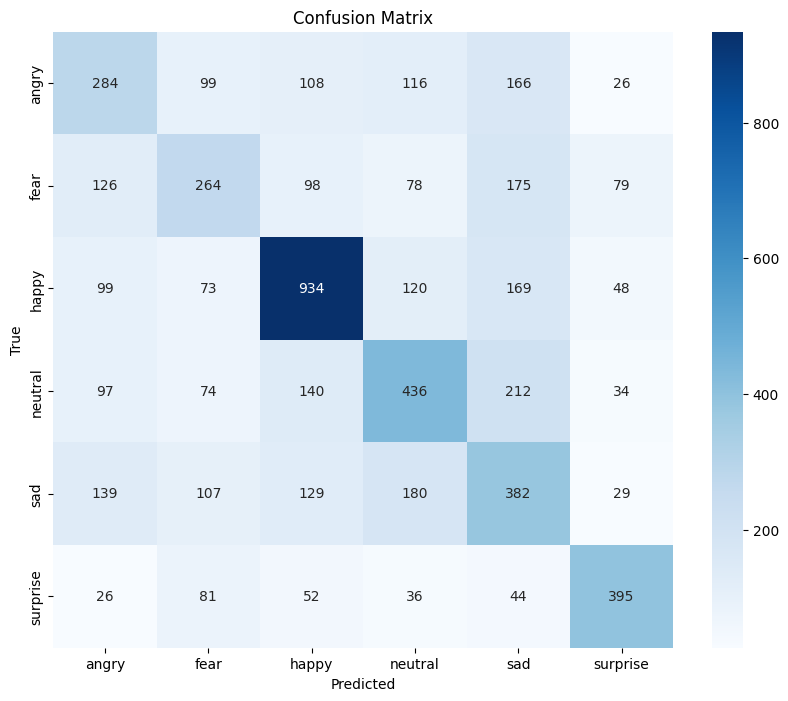

In [10]:
y_true = np.argmax(test_labels, axis=1)
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)

class_names = classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
test_image_path = r''
test_image = preprocess_image(test_image_path)
test_image = tf.expand_dims(test_image, axis=0)

prediction = model.predict(test_image)
predicted_class = np.argmax(prediction)
print(f"Predicted Class Index: {predicted_class}")

class_labels = ["angry", "fear", "happy", "neutral", "sad", "surprise"]
pred_label = class_labels[predicted_class]

plt.imshow(plt.imread(test_image_path))
plt.title(f"Predicted Class: {predicted_class}, Predicted Label: {pred_label}")
plt.axis('off')
plt.show()

2025-07-20 23:05:26.698537: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at whole_file_read_ops.cc:117 : NOT_FOUND: ; No such file or directory
2025-07-20 23:05:26.698557: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: NOT_FOUND: ; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} ; No such file or directory [Op:ReadFile]